In [2]:
import praw
from dotenv import dotenv_values

config = dotenv_values(".env")

reddit = praw.Reddit(
    client_id=config["CLIENT_ID"],
    client_secret=config["CLIENT_SECRET"],
    user_agent=config["USER_AGENT"],
)

In [3]:
import re

from nrclex import NRCLex

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def analyze_emotion(text: str) -> str:
    lexicon = NRCLex(clean_text(text))
    emotions = lexicon.affect_frequencies
    dominant_emotion = max(emotions, key=emotions.get)
    return dominant_emotion

In [33]:
from datetime import datetime

subreddit = reddit.subreddit("worldnews")
submissions = []

for post in subreddit.top(time_filter="month"):
    submissions.append([
        post.title,
        post.num_comments,
        datetime.utcfromtimestamp(post.created_utc),
        post.author,
        post.score,
        post.upvote_ratio,
        post.num_crossposts,
        analyze_emotion(post.title),
    ])

In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

for post in submissions:
    score = analyzer.polarity_scores(clean_text(post[0]))
    del score["compound"]
    post.extend(score.values())

In [35]:
import pandas as pd

df = pd.DataFrame(
    submissions,
    columns=["title", "comments", "created", "author", "upvotes", "upvote_ratio", "crossposts", "emotion", "negative", "neutral", "positive"],
)

In [36]:
df

,title,comments,created,author,upvotes,upvote_ratio,crossposts,emotion,negative,neutral,positive
0,Senior US lawmaker confirms Egypt warned Israe...,3791,2023-10-11 15:55:19,AmatuerNetworkist,34771,0.93,10,fear,0.189,0.811,0.000
1,Israel resumes water supply to southern Gaza a...,5270,2023-10-15 15:33:34,HappyBavarian,33053,0.91,4,positive,0.196,0.804,0.000
2,Residents near Gaza border beg for help: 'They...,9324,2023-10-07 08:37:07,Mazcal,30539,0.87,9,negative,0.190,0.693,0.117
3,Israel says no humanitarian break to Gaza sieg...,13626,2023-10-12 09:06:02,project_95,29976,0.89,7,surprise,0.148,0.671,0.181
4,Hamas official promises: 'We'll repeat Oct. 7 ...,7415,2023-11-01 12:57:50,BinaryPhinary2,28214,0.78,13,fear,0.000,0.657,0.343
...,...,...,...,...,...,...,...,...,...,...,...
95,UN votes overwhelmingly to condemn US economic...,1428,2023-11-02 17:15:22,Majano57,8968,0.92,0,negative,0.241,0.647,0.112
96,Hamas is hoarding vast amounts of fuel as Gaza...,1251,2023-11-02 14:01:40,DaDerpyDude,8753,0.85,1,fear,0.130,0.870,0.000
97,Three ISIS-supporting teens were arrested for ...,656,2023-10-22 19:39:51,Kooker321,8592,0.93,1,positive,0.341,0.659,0.000
98,Egypt moves to prevent exodus of Palestinians ...,1731,2023-10-11 12:27:00,Bangex,8596,0.96,0,fear,0.000,0.891,0.109


<Axes: title={'center': 'Distribution of Emotions on r/GeoPolitics'}, xlabel='emotion', ylabel='count'>

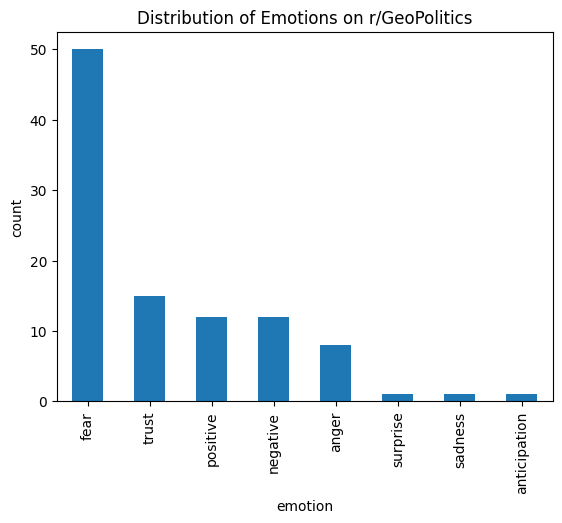

In [17]:
emotion_count = df.emotion.value_counts()
emotion_count.plot.bar(xlabel="emotion", ylabel="count", title="Distribution of Emotions on r/GeoPolitics")